# VSM BASELINE
1. [x] BERT MEAN

### evaluation
1. TA as classification
    * [x] cls report
    * [x] confusion matrix
    * [x] kappa
2. TA as regression
    * [x] MAE
    * [x] correlation
    * [x] prediction plot
3. Clusters
    * [x] task clusters
    * [x] bin clusters

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from scipy import stats
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
import umap
import random
import eval_utils
import itertools

In [4]:
df = pd.read_csv("../../data/finnish_average.csv")

# BERT VSMs
1. [x] embed everything and put vectors into a dataframe
    * [x] BERT MEAN
2. [x] go fold by fold and collect mean scores

In [5]:
import progressbar
from time import sleep

In [7]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, transcripts):
        self.transcripts = transcripts

    def __len__(self):
        return len(self.transcripts)

    def __getitem__(self, transcript_id):
        item = {}
        item['transcripts'] = self.transcripts[transcript_id]

        return item
    
def get_mean_dict(sentences, model, tokenizer):
    
    sentences = list(set(sentences))   
    sent_dataset = BERTDataset(sentences)
    data_generator = torch.utils.data.DataLoader(sent_dataset, batch_size=32, shuffle=False)
    
    MEANs = torch.tensor([])
    
    bar = progressbar.ProgressBar(maxval=len(data_generator), 
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start() 
    for i, batch in enumerate(data_generator):
        encodings = tokenizer(batch['transcripts'], padding=True, return_tensors="pt" )
        with torch.no_grad():
            output = model(input_ids=encodings['input_ids'], attention_mask=encodings['attention_mask'])
        token_embeddings = output[0]
        input_mask_expanded = encodings['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
        MEAN = torch.sum(token_embeddings*input_mask_expanded,1)/torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        MEANs = torch.cat((MEANs, MEAN), 0)
        bar.update(i+1)
        sleep(0.1)
    embeddings = MEANs.detach().numpy()
    embed_dict = {sent: emb for sent, emb in zip(sentences, embeddings)}   
    bar.finish()
    return embed_dict

In [6]:
bert_tokenizer = AutoTokenizer.from_pretrained("TurkuNLP/bert-base-finnish-cased-v1")
bert_model = AutoModel.from_pretrained("TurkuNLP/bert-base-finnish-cased-v1")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/816k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
mean_embed_dict = get_mean_dict(df['clean_transcript'], bert_model, bert_tokenizer)
mean_embeds = [mean_embed_dict[t] for t in df['clean_transcript']]
df['mean_embeds'] = mean_embeds

[========================================================================] 100%


In [9]:
mean_embed_asr_dict = get_mean_dict(df['asr_transcript'], bert_model, bert_tokenizer)
mean_asr_embeds = [mean_embed_asr_dict[t] for t in df['asr_transcript']]
df['mean_asr_embeds'] = mean_asr_embeds

[========================================================================] 100%


In [10]:
def get_mean_score_by_fold_bert(df, train_embed_column, test_embed_column, criterion, n=1):
    all_y_pred = []
    all_y_true = []
    sample_to_pred = {}
    
    for s in df['split'].unique():
        y_pred = []
        y_true = []
        train_df = df[df['split']!=s]
        test_df = df[df['split']==s]
        
        for i, row in test_df.iterrows():
            q_vec = row[test_embed_column]
            task = row['task']
            task_df = train_df[train_df['task']==task]
            task_vecs = task_df[train_embed_column].tolist()

            cosines = metrics.pairwise.cosine_similarity([q_vec], task_vecs)[0]
            vector_ids = np.argsort(cosines*-1) # inds of task responses sorted by their proximity
            closest_answers = vector_ids[:n] # inds of n closest responses
            values = task_df[criterion].values[closest_answers]
            mean_score = np.mean(values)
            y_pred.append(mean_score)
            y_true.append(row[criterion])
            
            sample_to_pred[row['sample']]=mean_score
       
        all_y_pred+=y_pred
        all_y_true+=y_true
        
    
    return all_y_pred, all_y_true, sample_to_pred

In [11]:
def get_mean_centroid_score_by_fold_bert(df, train_embed_column, test_embed_column, bin_column, n=1):
    all_y_pred = []
    all_y_true = []
    sample_to_pred = {}
    
    for s in df['split'].unique():
        y_pred = []
        y_true = []
        train_df = df[df['split']!=s]
        test_df = df[df['split']==s]
        
        for i, row in test_df.iterrows():
            q_vec = row[test_embed_column]
            task = row['task']
            task_df = train_df[train_df['task']==task]
            task_vecs = task_df[train_embed_column].tolist()
            
            unique_bins = task_df[bin_column].unique()
            bin_mean_vecs = []

            for bin_val in unique_bins:
                bin_df = task_df[task_df[bin_column] == bin_val]
                bin_vecs = bin_df[train_embed_column].values
                bin_mean_vec = np.mean(bin_vecs, axis=0)
                bin_mean_vecs.append(bin_mean_vec)

            cosines = metrics.pairwise.cosine_similarity([q_vec], bin_mean_vecs)[0]
            vector_ids = np.argsort(cosines*-1) # inds of task responses sorted by their proximity
            closest_answer = vector_ids[0] # inds of n closest responses
            bin_value = unique_bins[closest_answer]
            y_pred.append(bin_value)
            sample_to_pred[row['sample']]=bin_value
            y_true.append(row[bin_column])
       
        all_y_pred+=y_pred
        all_y_true+=y_true
        
    
    return all_y_pred, all_y_true, sample_to_pred

In [12]:
mean_pred, y_true, mean_sample_to_pred = get_mean_score_by_fold_bert(df, 'mean_embeds','mean_embeds',
                                                                        'task_completion_mean', n=1)

mean_asr_pred, y_true, mean_asr_sample_to_pred = get_mean_score_by_fold_bert(df, 'mean_embeds','mean_asr_embeds',
                                                                        'task_completion_mean', n=1)

In [13]:
mean_pred_centroid, y_true_centroid, mean_sample_to_pred_centroid = get_mean_centroid_score_by_fold_bert(df, 'mean_embeds',
                                                                                                   'mean_embeds',
                                                                                                   'ta_bins')

mean_asr_pred_centroid, y_true_centroid, mean_asr_sample_to_pred_centroid = get_mean_centroid_score_by_fold_bert(df, 'mean_embeds',
                                                                                                   'mean_asr_embeds',
                                                                                                   'ta_bins')

In [14]:
df['bert_mean'] = [mean_sample_to_pred[s] for s in df['sample']]
df['bert_mean_asr'] = [mean_asr_sample_to_pred[s] for s in df['sample']]
df['bert_mean_centroid'] = [mean_sample_to_pred_centroid[s] for s in df['sample']]
df['bert_mean_asr_centroid'] = [mean_asr_sample_to_pred_centroid[s] for s in df['sample']]

## evaluate
### TA as classification
* [x] get real score bin
* [x] get predicted score bin
* [x] treat it as classification
    * [x] cls report
    * [x] confusion matrix

              precision    recall  f1-score   support

           1       0.33      0.20      0.25       134
           2       0.26      0.20      0.23       339
           3       0.81      0.87      0.84      1639

    accuracy                           0.72      2112
   macro avg       0.47      0.43      0.44      2112
weighted avg       0.69      0.72      0.71      2112



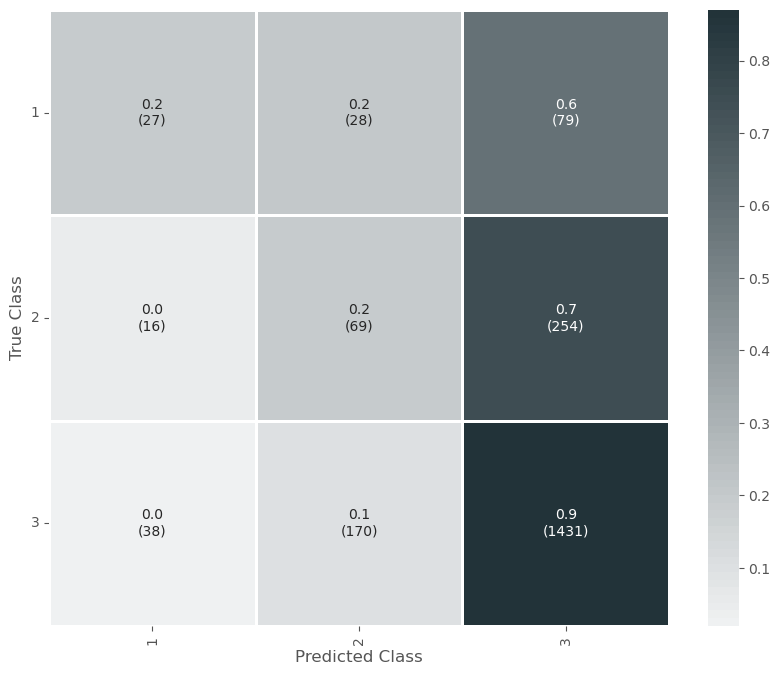

In [15]:
eval_utils.evaluate_cls(df['task_completion_mean'].tolist(), df['bert_mean'].tolist(), [1,3])

              precision    recall  f1-score   support

           1       0.32      0.19      0.23       134
           2       0.25      0.22      0.24       339
           3       0.82      0.86      0.84      1639

    accuracy                           0.72      2112
   macro avg       0.46      0.42      0.44      2112
weighted avg       0.69      0.72      0.70      2112



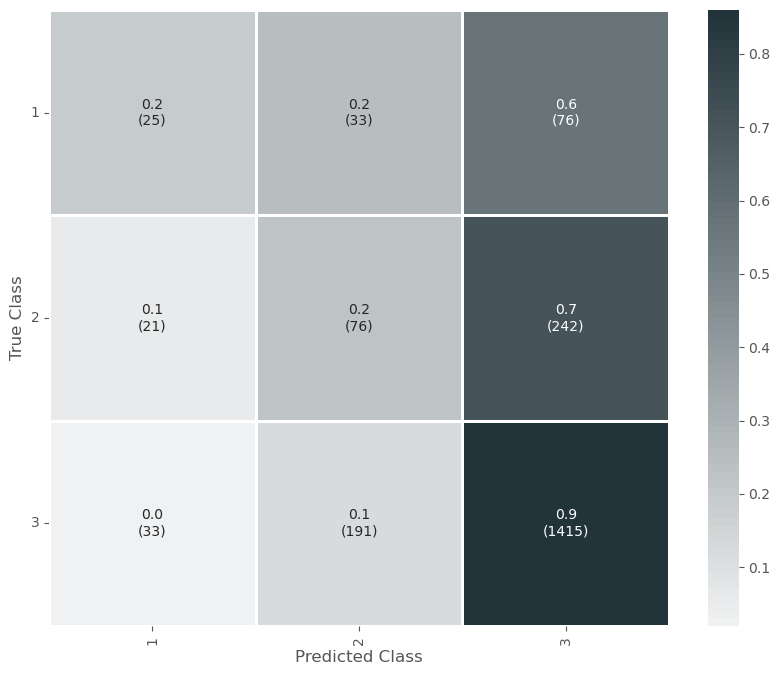

In [16]:
eval_utils.evaluate_cls(df['task_completion_mean'].tolist(), df['bert_mean_asr'].tolist(), [1,3])

              precision    recall  f1-score   support

           1       0.30      0.30      0.30       134
           2       0.26      0.34      0.30       339
           3       0.84      0.79      0.82      1639

    accuracy                           0.69      2112
   macro avg       0.47      0.48      0.47      2112
weighted avg       0.72      0.69      0.70      2112



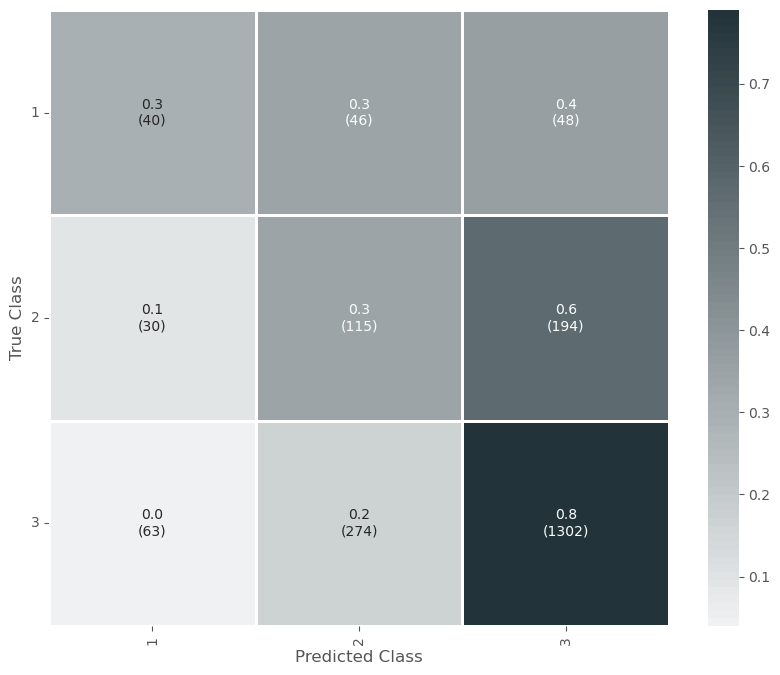

In [17]:
eval_utils.evaluate_cls(df['task_completion_mean'].tolist(), df['bert_mean_centroid'].tolist(), [1,3])

              precision    recall  f1-score   support

           1       0.31      0.30      0.30       134
           2       0.25      0.34      0.29       339
           3       0.84      0.78      0.81      1639

    accuracy                           0.68      2112
   macro avg       0.47      0.47      0.47      2112
weighted avg       0.71      0.68      0.69      2112



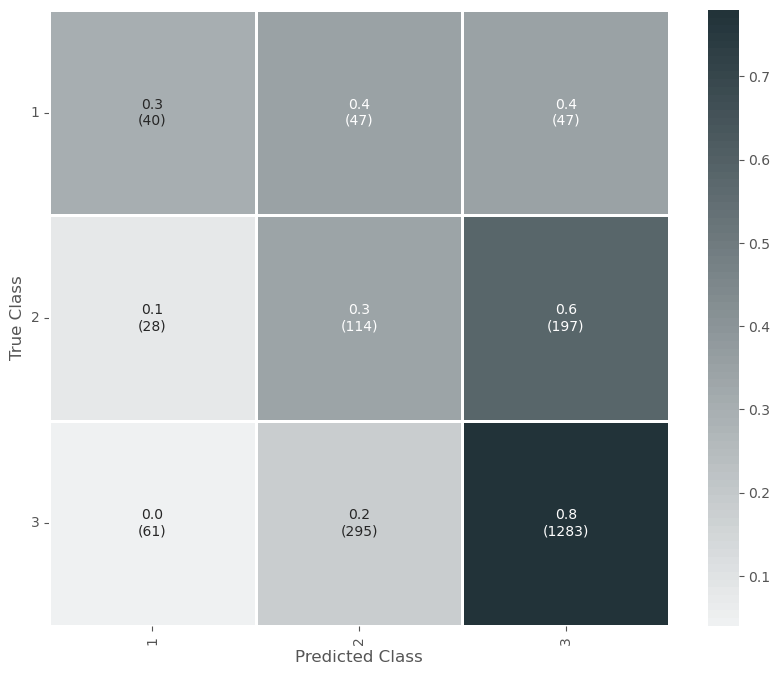

In [19]:
eval_utils.evaluate_cls(df['task_completion_mean'].tolist(), df['bert_mean_asr_centroid'].tolist(), [1,3])

### TA as regression
* [x] MAE
* [x] correlation
* [x] prediction plot

MAE:  0.37671953914141415
MAE to cls:  0.33238636363636365
Correlation:  0.25924493942765736
Correlation cls:  0.20510559388524102
Kappa: 0.23241331590681935


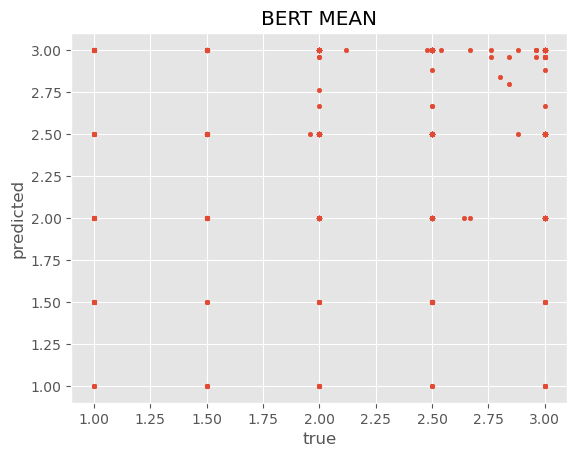

In [21]:
eval_utils.evaluate_reg(df['task_completion_mean'].tolist(), df['bert_mean'].tolist(), "BERT MEAN",[1,3])

MAE:  0.37053582702020205
MAE to cls:  0.3338068181818182
Correlation:  0.2773905440100447
Correlation cls:  0.22303774887348746
Kappa: 0.24821016745212077


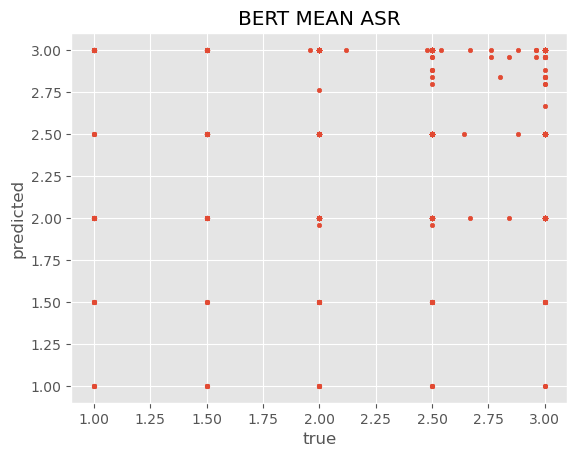

In [22]:
eval_utils.evaluate_reg(df['task_completion_mean'].tolist(), df['bert_mean_asr'].tolist(), "BERT MEAN ASR", [1,3])

MAE:  0.4096803977272727
MAE to cls:  0.3626893939393939
Correlation:  0.2863778719724623
Correlation cls:  0.28655164237188196
Kappa: 0.3134396520239925


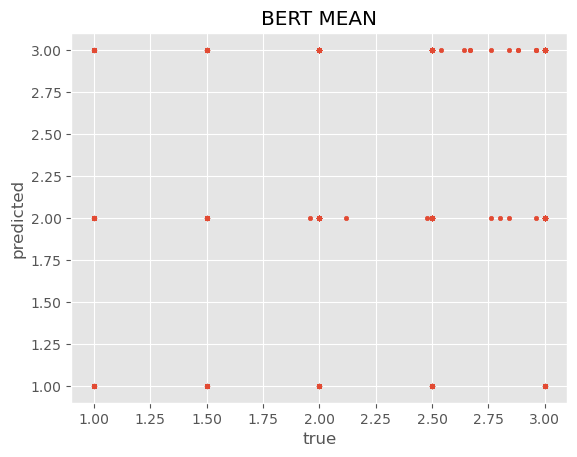

In [24]:
eval_utils.evaluate_reg(df['task_completion_mean'].tolist(), df['bert_mean_centroid'].tolist(), "BERT MEAN", [1,3])

MAE:  0.4126791351010101
MAE to cls:  0.37073863636363635
Correlation:  0.2792672929040204
Correlation cls:  0.271790144204119
Kappa: 0.30460095159370204


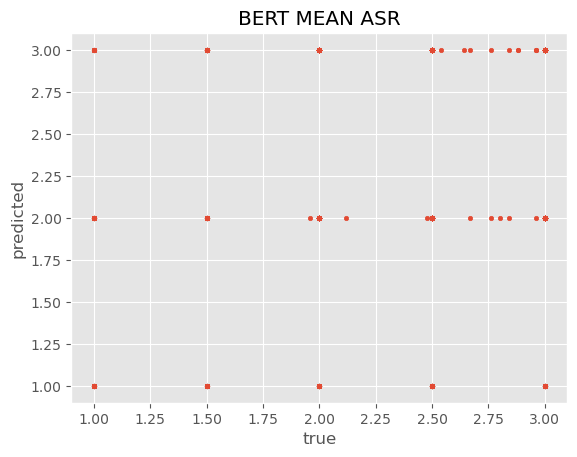

In [25]:
eval_utils.evaluate_reg(df['task_completion_mean'].tolist(), df['bert_mean_asr_centroid'].tolist(), "BERT MEAN ASR", [1,3])

### CLUSTERING
1. [x] TASKS
    * [x] average centroid distance
    * [x] cluster score
2. [x] SCORE BINS
    * [x] average centroid distance by task
    * [x] cluster score by task
    * [x] mean av centroid distance
    * [x] mean cluster score by task


In [29]:
eval_utils.compute_task_scores(df, 'task', 'mean_embeds')

TASK CENTROID DISTANCE:  0.18342489
CLUSTER SCORE: 57.85935888742787


In [27]:
eval_utils.compute_task_scores(df, 'task', 'mean_asr_embeds')

TASK CENTROID DISTANCE:  0.17878644
CLUSTER SCORE: 58.807805070141754


### bin scores

In [30]:
eval_utils.compute_bin_scores(df, 'mean_embeds', 'ta_bins')

BIN DISTANCES:  0.07122013
BIN CLUSTER SCORE:  1.7939874621234533


In [31]:
eval_utils.compute_bin_scores(df, 'mean_asr_embeds', 'ta_bins')

BIN DISTANCES:  0.0712672
BIN CLUSTER SCORE:  1.7500630060081495


In [32]:
def get_score_centroids(df, embed_column):
    task_scores = {}
    task_centroid_distances = []
    for t in df['task'].unique():
        task_df = df[df['task']==t].copy()
        score_centroids = {}
        for b in task_df['ta_bins'].unique():
            bin_df = task_df[task_df['ta_bins']==b].copy()
            bin_embeddings = np.vstack(bin_df[embed_column])
            bin_centroid = np.array(bin_embeddings).mean(axis=0)
            score_centroids[b] = bin_centroid
        task_scores[t]=eval_utils.get_centroid_distances(score_centroids)['distance'].mean()
        task_centroid_distances.append(eval_utils.get_centroid_distances(score_centroids))
    return task_scores, task_centroid_distances

In [39]:
a, b = get_score_centroids(df, 'mean_embeds')

In [40]:
average_bin = {"1_2":0, "1_3":0, "2_3":0}
for task in b:
    for _, row in task.iterrows():
        l1 = row['label_1']
        l2 = row['label_2']
        dist = row['distance']
        labels = [int(l1),int(l2)]
        labels.sort()
        if str(labels[0])+"_"+str(labels[1]) == "1_2":
            average_bin["1_2"]+=dist
        elif str(labels[0])+"_"+str(labels[1]) == "1_3":
            average_bin["1_3"]+=dist
        else:
            average_bin["2_3"]+=dist
            

In [41]:
for key in average_bin.keys():
    average_bin[key] /= len(b)

In [42]:
average_bin

{'1_2': 0.08187957384206097,
 '1_3': 0.07710302996866662,
 '2_3': 0.03599621691130873}